In [2]:
%load_ext autoreload

%autoreload 2
import GCRCatalogs
import matplotlib.pyplot as plt
import pickle
import sys
from astropy.table import QTable, Table, vstack, join 
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.table import Table, QTable
from astropy import units as u
from astropy.coordinates import SkyCoord, match_coordinates_3d
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
import iminuit
from iminuit import Minuit
cosmo_astropy.critical_density(0.4).to(u.Msun / u.Mpc**3).value
%load_ext autoreload

%autoreload 2
sys.path.append('/pbs/throng/lsst/users/cpayerne/CLMassDC2/modules/')
import CL_WL_miscentering as mis
import CL_WL_DATAOPS_make_profile as prf
import CL_WL_two_halo_term as twoh
import CL_WL_mass_conversion as utils
import CL_WL_fit_cluster_mass as fit
import CL_Likelihood_for_Mass_richness_relation as mr

import clmm
import clmm.dataops
from clmm.dataops import compute_tangential_and_cross_components, make_radial_profile, make_bins
from clmm.galaxycluster import GalaxyCluster
import clmm.utils as u
from clmm import Cosmology
from clmm.support import mock_data as mock
import pyccl as ccl
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_ccl  = ccl.Cosmology(Omega_c=0.265-0.0448, Omega_b=0.0448, h=0.71, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
profile = prf.load_profile(profile_name = '/pbs/throng/lsst/users/cpayerne/CLMassDC2/data/individual_profile_CLMM.pkl', 
                       r_in = 'radius_av', gt_in = 'gt_av', gx_in = 'gx_av', weight = 'norm_sum', rmin = 1, rmax = 5)

In [19]:
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
z_corner = np.linspace(0.2, 0.4, 4)
Z_bin = binning(z_corner)
m_corner = np.logspace(14,14.5,4)
Mass_bin = binning(m_corner)

In [20]:
profile_mock = prf.stacked_profile(profile = profile,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    z_name = 'cluster_z', obs_name = 'M200c',
                    Z_bin = Z_bin, Obs_bin = Mass_bin)

covariance_mock = prf.bootstrap_covariance(profile = profile,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    n_boot = 400,
                    z_name = 'cluster_z', obs_name = 'M200c',
                    Z_bin = Z_bin, Obs_bin = Mass_bin)

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/numpy/ma/core.py:2832: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  order=order, subok=True, ndmin=ndmin)


In [21]:
fit_mock = fit.fit_WL_cluster_mass(profile = profile_mock, covariance = covariance_mock, a = 0, b = .8, rmax = 5, two_halo_term = False, fix_c = True)

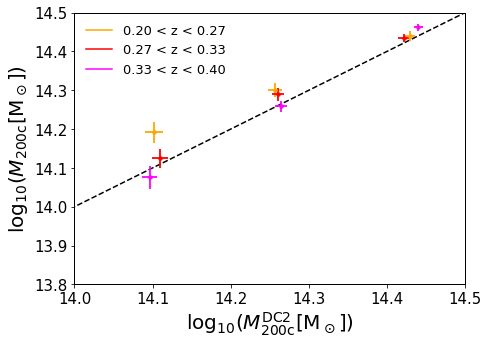

In [22]:
fit_label = [r'$M200c$',r'$Mfof$']
import matplotlib.pyplot as plt
plt.figure(figsize = (7,5))
plt.rcParams['axes.linewidth']= 1
plt.tick_params(axis='both', which = 'major', labelsize= 15)
color_fit = ['k','r','b']
color_z = ['orange','red','magenta','purple','green','cyan','blue','black']
marker = ['s','o','^','.']
marker_fit = ['-',':','-','-']

for i, z_bin in enumerate(Z_bin):
    
    plt.plot([],[], '-', c = color_z[i],label = f'{z_bin[0]:.2f} < z < {z_bin[1]:.2f}',)
    
    f = fit_mock

    mask = (f['z_mean'] > z_bin[0])*(f['z_mean'] < z_bin[1])

    mask = mask

    f_cut = f[mask]

    a_t = 1./(1 + f_cut['z_mean'])

    logm = np.log10(f_cut['obs_mean']) 
    logm_err = f_cut['obs_rms']/(np.log(10)*(f_cut['obs_mean']))
    logm200w = f_cut['logm200_w']
    logm200w_err = f_cut['logm200_w_err']

    plt.errorbar(logm,logm200w,logm200w_err, logm_err,\
                marker = '.', fmt= ' ', color = color_z[i], capsize = 0,markersize=7,\
                elinewidth=2,linewidth=1.5, alpha = 0.9)

ylabel = r'$\log_{10}($' + r'$M_{\rm 200c}$' + r'$[\rm{M}_\odot])$'
xlabel = r'$\log_{10}($' + r'$M_{\rm 200c}^{\rm DC2}$' + r'$[\rm{M}_\odot])$'
#xlabel = r'$\log_{10}($' + r'$M_{\rm fof}^{\rm DC2}$' + r'$[\rm{M}_\odot])$'
m = np.linspace(13,15,10)
plt.plot(m,m,'--k',zorder = 1, alpha = 1)
plt.xlim(14,14.5)
plt.ylim(13.8,14.5)
plt.ticklabel_format(useOffset=False)
plt.xlabel(xlabel, fontsize = 20)
plt.ylabel(ylabel, fontsize = 20)
plt.legend(loc='upper left', frameon = False, fontsize = 13, numpoints = 1)
#plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/M200cw_M200c_validation.png', bbox_inches='tight', dpi=300)

3 3


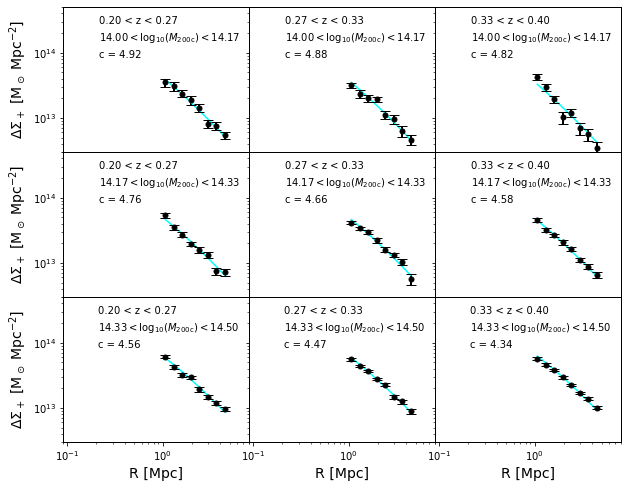

In [23]:
n_z_bin = len(Z_bin) - 0
n_m_bin = len(Mass_bin) - 0
print(n_z_bin, n_m_bin)
scale = 3
fig, axs = plt.subplots(n_m_bin,n_z_bin, figsize = (10,8), sharex = True, sharey = True)
fig.subplots_adjust(wspace=0, hspace=0)
for j, z_bin in enumerate(Z_bin):

    if j >= n_z_bin: continue
        
    for i, m_bin in enumerate(Mass_bin):

        if i >= n_m_bin: continue
            
        label_z = f'{z_bin[0]:.2f} < z < {z_bin[1]:.2f}'
        label_M = f'{np.log10(m_bin[0]):.2f}' + r'$ < \log_{10}(M_{\rm 200c}) < $' + f'{np.log10(m_bin[1]):.2f}'
        axs[i, j].plot([], [], 'w', label = label_z)
        axs[i, j].plot([], [], 'w', label = label_M)
        c = ['r','b']
        fmt = ['-', '--']
        marker = ['o', 's']
        markersize = [2,2]
        profile_ = fit_mock
        covariance = [covariance_mock]
        mask_z = (profile_['z_mean'] > z_bin[0])*(profile_['z_mean'] < z_bin[1])
        mask_m = (profile_['obs_mean'] > m_bin[0])*(profile_['obs_mean'] < m_bin[1])
        index = np.arange(len(profile_))
        index_cut = index[mask_m * mask_z]
        f_cut = profile_[index_cut]
        if len(f_cut) == 0: continue
        gt_err = np.array(covariance[0][index_cut]['gt_err'][0])
        axs[i, j].plot(f_cut['radius_model'][0], f_cut['1h_term'][0], '-', c = 'cyan')
        cfiducial = 4
       
        mask = f_cut['mask'][0]
        axs[i, j].errorbar(f_cut['radius_model'][0][mask], f_cut['gt'][0][mask],gt_err[mask], c = 'k'
                           ,marker = 'o',fmt = ' ', elinewidth = 2, capsize = 5, markersize = 5, markerfacecolor = None)
        axs[i, j].errorbar(f_cut['radius_model'][0][np.invert(mask)], f_cut['gt'][0][np.invert(mask)],gt_err[np.invert(mask)],  c = 'cyan'
                           ,marker = 'o',fmt = ' ', elinewidth = 2, capsize = 5, markersize = 5, markerfacecolor = None)
        c = f_cut['c_w'][0]
        label_n = f'c = {c:.2f}'
        axs[i, j].plot([], [], 'w', label = label_n)
        axs[i, j].set_ylim(3e12, 5e14)
        axs[i, j].set_xlim(0.09, 8)
        axs[i, j].set_xscale('log')
        axs[i, j].set_yscale('log')
        axs[i, j].legend(frameon = False, loc = 'upper right', fontsize = 10)
        axs[i, j].set_xlabel('R [Mpc]', fontsize = 14)
        axs[i, j].set_ylabel(r'$\Delta\Sigma_+$ ' +'$[$' + r'${\rm M}$' + r'$_\odot\;$'+ r'${\rm Mpc}$'+r'$^{-2}$'r'$]$', fontsize = 14)

for ax in fig.get_axes():
    ax.label_outer()
#plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/profile_attenuation.png', bbox_inches='tight', dpi=300)